The idea of transfer learning comes from a curious phenomenon that many deep neural networks trained on natural images learn features similar to Gabor filters and color blobs in the first layer. Such first-layer features appear not to specific to a particular dataset or task but are general in that they are applicable to many datasets and tasks. 
As finding these standard features on the first layer seems to occur regardless of the exact cost function and natural image dataset, we call these first-layer features general and can be transferred for learning specific datasets. 

In transfer learning we first train a base network on a base dataset and task, and then we transfer the learned features, to a second target network to be trained on a target dataset and task. This process will tend to work if the features are general, that is, suitable to both base and target tasks, instead of being specific to the base task.

In practice, very few people train an entire Convolutional Network from scratch because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pre-train a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the pre-trained model either as an initialization or a fixed feature extractor for the task of interest.

The advantages of transfer learning are that:
1. There is no need of an extremely large training data-set.
2. Not much computational power is required.As we are using pre-trained weights and only have to learn the weights of the last few layers.

There are two ways to do transfer learning.
1. Feature Extraction from pre-trained model and then training a classifer on top of it.
2. Fine tuning the pre-trained model keeping learnt weights as initial parameters.

<u>Problem Description</u>


In this blog-post, We will use a dataset containing 16643 food images grouped in 11 major food categories for transfer learning demonstration. The 11 categories are: 
* Bread
* Dairy product
* Dessert
* Egg
* Fried food
* Meat
* Noodles/Pasta
* Rice
* Seafood
* Soup
* Vegetable/Fruit 

The Food-11 dataset is divided in three parts: training, validation and evaluation. The naming convention is used, where ID 0-10 refers to the 11 food categories respectively. This is a food classification task.

Lets start with python codes on transfer learning with feature extraction technique.

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Library" data-toc-modified-id="Import-Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Library</a></span></li><li><span><a href="#Reading-Data" data-toc-modified-id="Reading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading Data</a></span><ul class="toc-item"><li><span><a href="#Create-labels" data-toc-modified-id="Create-labels-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create labels</a></span></li><li><span><a href="#Train,-Validation-and-Test-Distribution" data-toc-modified-id="Train,-Validation-and-Test-Distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train, Validation and Test Distribution</a></span></li><li><span><a href="#Sample-Images" data-toc-modified-id="Sample-Images-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sample Images</a></span></li></ul></li><li><span><a href="#Features-Extraction" data-toc-modified-id="Features-Extraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Features Extraction</a></span></li><li><span><a href="#CNN-Model-Training-:-Scratch" data-toc-modified-id="CNN-Model-Training-:-Scratch-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CNN Model Training : Scratch</a></span><ul class="toc-item"><li><span><a href="#Test-Evaluation" data-toc-modified-id="Test-Evaluation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test Evaluation</a></span></li></ul></li><li><span><a href="#Transfer-Learning-CNN-:-VGG16-Features" data-toc-modified-id="Transfer-Learning-CNN-:-VGG16-Features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transfer Learning CNN : VGG16 Features</a></span><ul class="toc-item"><li><span><a href="#Test-Evaluation" data-toc-modified-id="Test-Evaluation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Test Evaluation</a></span></li></ul></li><li><span><a href="#Logistic-Regression:-VGG16-Features" data-toc-modified-id="Logistic-Regression:-VGG16-Features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Logistic Regression: VGG16 Features</a></span><ul class="toc-item"><li><span><a href="#Test-Evaluation" data-toc-modified-id="Test-Evaluation-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Test Evaluation</a></span></li></ul></li></ul></div>

## Import Library

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 

# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Importing hypopt library for grid search 
from hypopt import GridSearch

# Importing Keras libraries 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Reading Data

In [3]:
train = [os.path.join("Food-11/training",img) for img in os.listdir("Food-11/training")]
val = [os.path.join("Food-11/validation",img) for img in os.listdir("Food-11/validation")]
test = [os.path.join("Food-11/evaluation",img) for img in os.listdir("Food-11/evaluation")]

In [4]:
len(train),len(val),len(test)

(9866, 3430, 3347)

In [5]:
train[0:5]

['Food-11/training/9_1339.jpg',
 'Food-11/training/2_1351.jpg',
 'Food-11/training/1_170.jpg',
 'Food-11/training/6_31.jpg',
 'Food-11/training/8_558.jpg']

### Create labels

In [6]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]

In [7]:
num_classes = 11
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [8]:
train_y[0:10]

[9, 2, 1, 6, 8, 6, 0, 9, 0, 9]

In [9]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

### Train, Validation and Test Distribution

Training data available in 11 classes
[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]


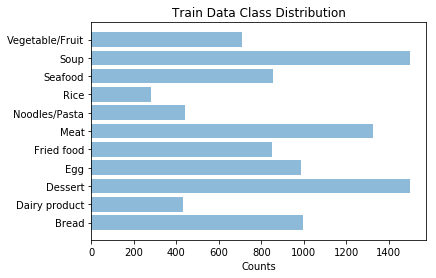

In [10]:
print("Training data available in 11 classes")
print([train_y.count(i) for i in range(0,11)])

food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')

y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,11)]

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')

plt.show()

In [11]:
print("Validation data available in 11 classes")
[val_y.count(i) for i in range(0,11)]

Validation data available in 11 classes


[362, 144, 500, 327, 326, 449, 147, 96, 347, 500, 232]

In [12]:
print("Test data available in 11 classes")
[test_y.count(i) for i in range(0,11)]

Test data available in 11 classes


[368, 148, 500, 335, 287, 432, 147, 96, 303, 500, 231]

### Sample Images

In [32]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()


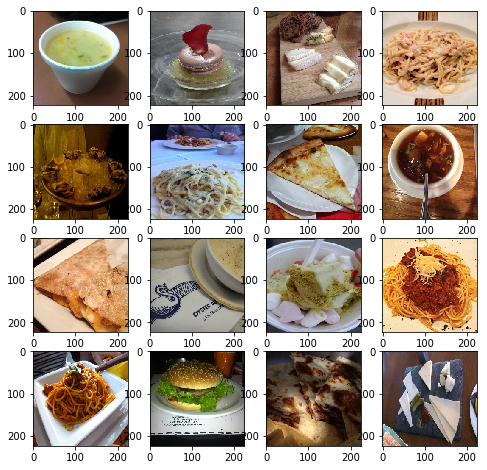

In [35]:
show_imgs(train)

## Features Extraction

Loading the pre-trained VGG16 Model

In [12]:
# load the VGG16 network and initialize the label encoder
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)
model.summary()

[INFO] loading network...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 12

Custom function to extract features of each image in Food-11 dataset using VGG16 model

In [13]:
def create_features(dataset, pre_model):
    
    x_scratch = []

    # loop over the images
    for imagePath in dataset:

        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        # add the image to the batch
        x_scratch.append(image)
        
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features, features_flatten

There are three types of features being extracted for each dataset train, val and test:
* preprocessed raw input image (224,224,3). Used for training CNN from scratch
* features extracted from last Convolution layer (7,7,512) of pre-trained VGG16. Used for transfer learning.
* flatten extracted features from VGG16 (25088). Used for training a logistic regression model. 

In [14]:
train_x, train_features, train_features_flatten = create_features(train, model)
val_x, val_features, val_features_flatten = create_features(val, model)
test_x, test_features, test_features_flatten = create_features(test, model)

In [31]:
print(train_x.shape, train_features.shape, train_features_flatten.shape)
print(val_x.shape, val_features.shape, val_features_flatten.shape)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

(9866, 224, 224, 3) (9866, 7, 7, 512) (9866, 25088)
(3430, 224, 224, 3) (3430, 7, 7, 512) (3430, 25088)
(3347, 224, 224, 3) (3347, 7, 7, 512) (3347, 25088)


## CNN Model Training : Scratch

In [32]:
# Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5', 
                               verbose=1,save_best_only=True)

# Building up a Sequential model
model_scratch = Sequential()
model_scratch.add(Conv2D(32, (3, 3), activation='relu',input_shape = train_x.shape[1:]))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(GlobalAveragePooling2D())
model_scratch.add(Dense(64, activation='relu'))
model_scratch.add(Dense(11, activation='softmax'))
model_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [33]:
model_scratch.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

#Fitting the model on the train data and labels.
history = model_scratch.fit(train_x, y_train, 
          batch_size=32, epochs=10, 
          verbose=1, callbacks=[checkpointer], 
          validation_data=(val_x, y_val), shuffle=True)

Train on 9866 samples, validate on 3430 samples
Epoch 1/10
9866/9866 [==============================] - 13s 1ms/step - loss: 3.0183 - acc: 0.2251 - val_loss: 2.0070 - val_acc: 0.2872

Epoch 00001: val_loss improved from inf to 2.00704, saving model to scratchmodel.best.hdf5
Epoch 2/10
9866/9866 [==============================] - 13s 1ms/step - loss: 1.9388 - acc: 0.3085 - val_loss: 1.9275 - val_acc: 0.3184

Epoch 00002: val_loss improved from 2.00704 to 1.92755, saving model to scratchmodel.best.hdf5
Epoch 3/10
9866/9866 [==============================] - 13s 1ms/step - loss: 1.8181 - acc: 0.3634 - val_loss: 1.7406 - val_acc: 0.3950

Epoch 00003: val_loss improved from 1.92755 to 1.74055, saving model to scratchmodel.best.hdf5
Epoch 4/10
9866/9866 [==============================] - 12s 1ms/step - loss: 1.7046 - acc: 0.4131 - val_loss: 1.7307 - val_acc: 0.4050

Epoch 00004: val_loss improved from 1.74055 to 1.73069, saving model to scratchmodel.best.hdf5
Epoch 5/10
9866/9866 [==========

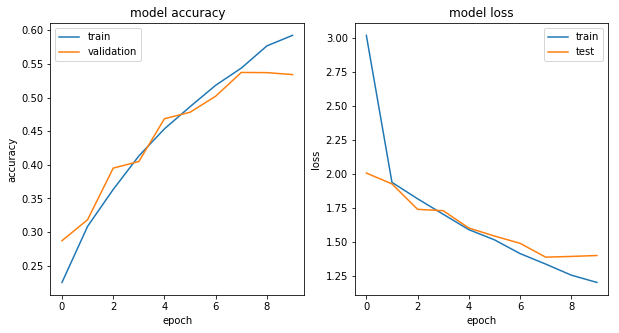

In [34]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


### Test Evaluation

In [35]:
preds = np.argmax(model_scratch.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))


Accuracy on Test Data:  0.5530325664774425

Number of correctly identified imgaes:  1851 



array([[ 54,   2,  24, 173,  22,  34,  15,   0,  19,  21,   4],
       [  1,  23,  45,  45,  10,  12,   0,   0,   2,  10,   0],
       [ 15,   4, 207,  97,  17,  74,   6,   0,  45,  27,   8],
       [  5,   2,   9, 283,   9,  12,   1,   0,   6,   8,   0],
       [  9,   1,  18,  80, 133,  19,   0,   0,   7,  16,   4],
       [  7,   0,  15,  34,   9, 350,   0,   0,   8,   7,   2],
       [  5,   0,   1,  50,   0,   8,  68,   0,   6,   6,   3],
       [  5,   1,  10,  31,   1,   6,  25,   9,   0,   6,   2],
       [  0,   0,  34,  38,   1,  32,   0,   0, 187,   8,   3],
       [  3,   5,  28,  44,   3,  33,   4,   0,  16, 364,   0],
       [  1,   0,   2,  36,   1,   4,   1,   0,  13,   0, 173]])

## Transfer Learning CNN : VGG16 Features

In [36]:
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(11, activation='softmax'))
model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_12 (Dense)             (None, 11)                1111      
Total params: 52,411
Trainable params: 52,411
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
history = model_transfer.fit(train_features, y_train, batch_size=32, epochs=10,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

Train on 9866 samples, validate on 3430 samples
Epoch 1/10
9866/9866 [==============================] - 1s 134us/step - loss: 1.8177 - acc: 0.5625 - val_loss: 0.8561 - val_acc: 0.7251

Epoch 00001: val_loss improved from 1.38955 to 0.85611, saving model to scratchmodel.best.hdf5
Epoch 2/10
9866/9866 [==============================] - 1s 92us/step - loss: 0.8891 - acc: 0.7130 - val_loss: 0.6920 - val_acc: 0.7738

Epoch 00002: val_loss improved from 0.85611 to 0.69205, saving model to scratchmodel.best.hdf5
Epoch 3/10
9866/9866 [==============================] - 1s 101us/step - loss: 0.7132 - acc: 0.7679 - val_loss: 0.6217 - val_acc: 0.8012

Epoch 00003: val_loss improved from 0.69205 to 0.62174, saving model to scratchmodel.best.hdf5
Epoch 4/10
9866/9866 [==============================] - 1s 132us/step - loss: 0.6371 - acc: 0.7899 - val_loss: 0.6141 - val_acc: 0.8020

Epoch 00004: val_loss improved from 0.62174 to 0.61411, saving model to scratchmodel.best.hdf5
Epoch 5/10
9866/9866 [===

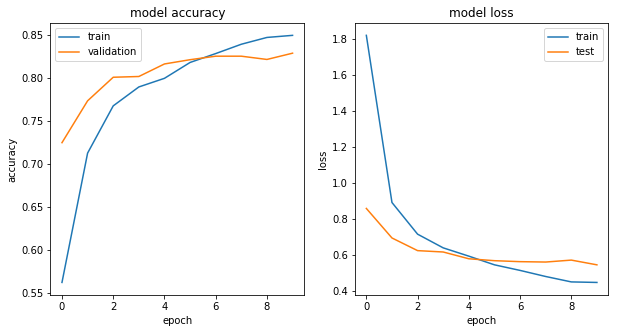

In [38]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Test Evaluation

In [39]:
preds = np.argmax(model_transfer.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))


Accuracy on Test Data:  0.8521063639079773

Number of correctly identified imgaes:  2852 



array([[295,   4,   1,  39,  21,   5,   0,   2,   0,   0,   1],
       [  4, 115,   7,   5,   2,   3,   0,   2,   5,   3,   2],
       [ 32,  20, 350,  26,  16,  18,   2,   2,  18,  13,   3],
       [ 27,   9,   9, 273,   4,   1,   0,   4,   3,   3,   2],
       [  6,   2,   5,  10, 253,   5,   0,   1,   3,   2,   0],
       [  9,   0,   9,  26,  12, 365,   1,   1,   7,   2,   0],
       [  0,   0,   0,   0,   4,   0, 141,   2,   0,   0,   0],
       [  2,   0,   1,   0,   0,   1,   0,  92,   0,   0,   0],
       [  4,   2,   8,   8,   0,   5,   0,   1, 271,   1,   3],
       [  2,   1,   8,   3,   2,   0,   0,   1,   3, 480,   0],
       [  0,   0,   3,   4,   1,   1,   0,   0,   5,   0, 217]])

## Logistic Regression: VGG16 Features

In [40]:
param_grid = [{'C': [0.1,1,10],'solver': ['newton-cg','lbfgs']}]

# Grid-search all parameter combinations using a validation set.
opt = GridSearch(model = LogisticRegression(class_weight='balanced', multi_class="auto", 
                        max_iter=200, random_state=1),param_grid = param_grid)

opt.fit(train_features_flatten, train_y, val_features_flatten, val_y, scoring = 'accuracy')
print(opt.get_best_params())

{'C': 0.1, 'solver': 'newton-cg'}


### Test Evaluation

In [41]:
opt.score(test_features_flatten, test_y)
preds = opt.predict(test_features_flatten)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
print("\nNumber of correctly identified imgaes: ",
      accuracy_score(test_y, preds, normalize=False),"\n")
confusion_matrix(test_y, preds, labels=range(0,11))


Accuracy on Test Data:  0.8503137137735285

Number of correctly identified imgaes:  2846 



array([[279,   1,  22,  30,  17,   9,   0,   0,   4,   3,   3],
       [  3, 112,  15,   4,   2,   3,   0,   1,   4,   3,   1],
       [ 16,  19, 381,  20,  11,  19,   1,   2,  13,  14,   4],
       [ 35,   4,  14, 267,   3,   1,   1,   2,   5,   3,   0],
       [  9,   2,  14,   2, 238,  12,   1,   1,   2,   5,   1],
       [  7,   0,  13,  13,  10, 378,   0,   0,   8,   3,   0],
       [  0,   0,   0,   2,   0,   0, 143,   1,   0,   1,   0],
       [  0,   0,   0,   1,   0,   2,   1,  90,   0,   0,   2],
       [  6,   4,  14,   3,   2,   9,   0,   1, 259,   1,   4],
       [  1,   2,   3,   3,   2,   0,   0,   0,   3, 485,   1],
       [  2,   1,   8,   1,   0,   1,   0,   0,   4,   0, 214]])